<a href="https://colab.research.google.com/github/maursa22/Predicting-Concrete-Compressive-Strength-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
%matplotlib inline

The dataset that I chose for this project consists of data from 1030 concrete samples. The data belongs to Prof. I-Cheng Yeh from Chung-Hua University. The link to the data is below:

https://www.kaggle.com/datasets/maajdl/yeh-concret-data?resource=download&select=Concrete_Data_Yeh.csv

The compressive strength of concrete depends on the ingredients put into the mix and the age of the concrete. Concrete is the second most common substance on Earth after water, and it is the most consumed material globally. More than 7 billion cubic meters of concrete are produced annually. Compressive strength is typically the most important factor under consideration when performing R&D on new concrete mixes. My day job is teaching technicians how to test fresh and hardened concrete, so I thought this would be an interesting topic to work with.

This dataset includes 8 input variables. Seven of these variables are ingredients: cement, slag cement, flyash, water, superplasticizer, coarse aggregate, and fine aggregate, all in kg per cubic meter. The 8th input variable is the age of the concrete in days. The output is the compressive strength of the concrete in MPa.

It's widely realized in the construction industry that cement content, or more specifically the water-cement ratio, is the most important factor for producing concrete with a high compressive strength. Superplasticizer or 'water reducing admixture' is a chemical admixture that is added to concrete that reduces the amount of water required to still produce concrete with a workable consistency. Slag cement and flyash are industrial byproducts that replace some of the cement content in a concrete mix. Flyash is often not cementitious by itself, but it reacts with calcium hydroxide (which is produced when cement hydrates with water) and becomes cementitious.

Link to project on github:

https://github.com/maursa22/Predicting-Concrete-Compressive-Strength-Project/tree/main

First thing is to read in the data and see how it looks.

In [25]:

df = pd.read_csv('/kaggle/Concrete_Data_Yeh.csv')
df.head()


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


The data looks pretty clean but I am going to convert the units for cement, slag, flyash, superplasticizer, coarse aggregate, and fine aggregate to lbs per cubic yard and the compressive strength from MPa to PSI.

In [26]:
conversion = 1.68555 #conversion factor for kg/m^3 to lb/yd^3

input_columns = df.columns[0:7]
df[input_columns] = df[input_columns]*conversion
df['csMPa'] = df['csMPa']*145.038 #conversion for MPa to PSI
df.rename(columns={'csMPa':'csPSI'}, inplace=True)
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csPSI
0,910.197000,0.000000,0.0,273.0591,4.213875,1752.97200,1139.431800,28,11601.58962
1,910.197000,0.000000,0.0,273.0591,4.213875,1778.25525,1139.431800,28,8976.40182
2,560.445375,240.190875,0.0,384.3054,0.000000,1570.93260,1001.216700,270,5840.68026
3,560.445375,240.190875,0.0,384.3054,0.000000,1570.93260,1001.216700,365,5953.80990
4,334.750230,223.166820,0.0,323.6256,0.000000,1649.14212,1391.421525,360,6425.18340


Next thing is to make a correlation matrix to see which feature may be the best predictor for compressive strength. I was curious to see what this would look like since it's well known in industry that cement content plays the most important role. I was glad to see that cement content was the most highly correlated with compressive strength, followed by superplasticizer content, and then age. I also visualized this correlation matrix as a heat map in the cell following the correlation matrix.

In [4]:
df.corr()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csPSI
cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
flyash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
superplasticizer,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
coarseaggregate,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
fineaggregate,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
csPSI,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


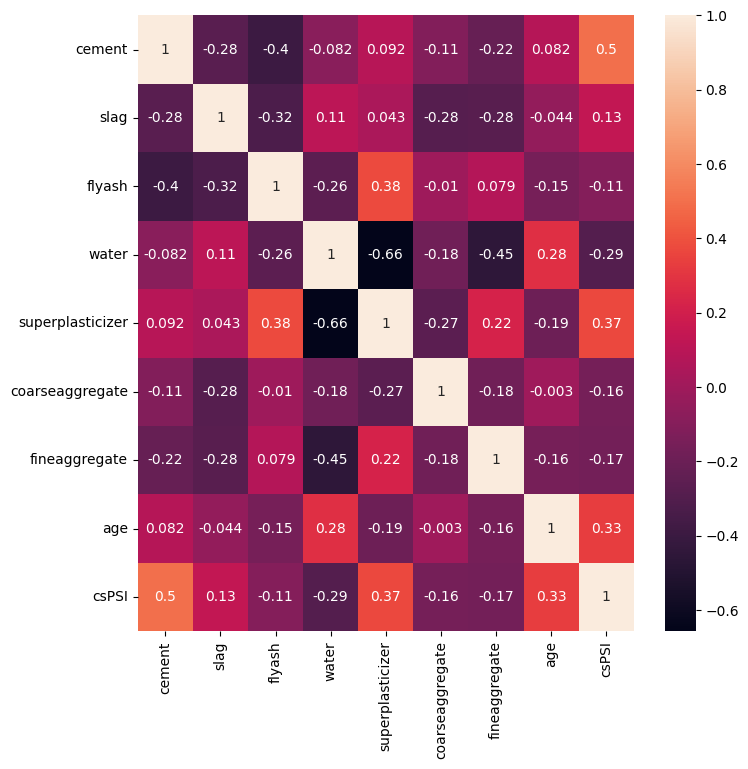

In [27]:
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(df.corr(), annot=True)

Next I build a single variable model for each predictor to see which features would be the best predictors. None of the models have very high r-squared values, but the three best are the models with cement (r-squared=0.248), superplasticizer (r-squared=0.134), and age (r-squared=0.108).

In [6]:
X = df.drop(columns=['csPSI'])
y = df['csPSI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
model = smf.ols(formula = 'csPSI ~ cement', data = df).fit()
print(model.summary())

model2 = smf.ols(formula = 'csPSI ~ superplasticizer', data = df).fit()
print(model2.summary())

model3 = smf.ols(formula = 'csPSI ~ age', data = df).fit()
print(model3.summary())

model4 = smf.ols(formula = 'csPSI ~ flyash', data = df).fit()
print(model4.summary())

model5 = smf.ols(formula = 'csPSI ~ water', data = df).fit()
print(model5.summary())

model6 = smf.ols(formula = 'csPSI ~ coarseaggregate', data = df).fit()
print(model6.summary())

model7 = smf.ols(formula = 'csPSI ~ fineaggregate', data = df).fit()
print(model7.summary())

model8 = smf.ols(formula = 'csPSI ~ slag', data = df).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:                  csPSI   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     338.7
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           1.32e-65
Time:                        22:15:46   Log-Likelihood:                -9340.9
No. Observations:                1030   AIC:                         1.869e+04
Df Residuals:                    1028   BIC:                         1.870e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1949.6774    188.107     10.365      0.0

Next I tried polynomial regression to see if I could do any better, similar to what we did in Week 2. I'm new at this so I am just experimenting. I fit the model for polynomial degrees up to 10. The best r-squared value that I got was .255 which is not much better than the best r-squared I got using simple linear regression above for the best predictor of cement (.248), so I'm going to scratch this and try multi-variate and see if I can do better.

In [8]:
best_degree = 1

best_r_squared = 0


for d in range(1,11):

    if d>1:
        powerstr = '+'.join(['np.power(cement,'+str(x)+')' for x in range(2, d+1)])
        model = smf.ols(formula='csPSI~cement+'+powerstr, data=df).fit()

    else:
        model = smf.ols(formula='csPSI~cement', data=df).fit()

    #print(model.summary())

    r2 = model.rsquared

    print(d, r2)
    if r2>best_r_squared:

        best_r_squared=r2

        best_degree=d

print('------------------------')

print(best_degree, best_r_squared)

1 0.24783661989797412
2 0.24790762985417747
3 0.2479157876943302
4 0.24883449383897926
5 0.2489978451900039
6 0.25403398304652336
7 0.25464033264247
8 0.22457791365889657
9 0.13383844882810014
10 -0.02175456777587459
------------------------
7 0.25464033264247


Next I'm going to try multiple linear regression to see if I can improve the model. The model with the best r-squared value is the model that includes all 8 of the features (r-squared=0.616). The model with the three best predictors only has an r-squared value of 0.482.

In [30]:
model9 = smf.ols(formula = 'csPSI ~ cement + age + superplasticizer', data = df).fit()
print(model9.summary())

model10 = smf.ols(formula = 'csPSI ~ cement + age + superplasticizer + water', data = df).fit()
print(model10.summary())

model11 = smf.ols(formula = 'csPSI ~ cement + age + superplasticizer + water + fineaggregate', data = df).fit()
print(model11.summary())

model12 = smf.ols(formula = 'csPSI ~ cement + age + superplasticizer + water + fineaggregate + coarseaggregate', data = df).fit()
print(model12.summary())

model13 = smf.ols(formula = 'csPSI ~ cement + age + superplasticizer + water + fineaggregate + coarseaggregate + slag', data = df).fit()
print(model13.summary())

model14 = smf.ols(formula = 'csPSI ~ cement + age + superplasticizer + water + fineaggregate + coarseaggregate + slag + flyash', data = df).fit()
print(model14.summary())



                            OLS Regression Results                            
Dep. Variable:                  csPSI   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     317.9
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          6.41e-146
Time:                        22:25:12   Log-Likelihood:                -9149.0
No. Observations:                1030   AIC:                         1.831e+04
Df Residuals:                    1026   BIC:                         1.833e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          737.8850    166.308  

The last thing I tried was adding interactions between the features. I added all of the interactions and then removed any that had P>0.05. The model that I ended up with includes all of the features and many interactions. The r-squared value is 0.737.

In [34]:
mod = smf.ols(formula = 'csPSI ~ cement + slag + flyash + superplasticizer + coarseaggregate  + water + fineaggregate + age + cement*water + cement*superplasticizer + slag*fineaggregate+ flyash*superplasticizer + flyash*water + flyash*age + superplasticizer*water + superplasticizer*coarseaggregate + superplasticizer*age + water*coarseaggregate  + water*age + coarseaggregate*fineaggregate ', data = df).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  csPSI   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     141.1
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          1.76e-275
Time:                        22:29:28   Log-Likelihood:                -8800.3
No. Observations:                1030   AIC:                         1.764e+04
Df Residuals:                    1009   BIC:                         1.775e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

The last thing I did was plot the predicted compressive strength against the actual compressive strength. In a lot of instances, the predicted strength is higher than the actual compressive strength. I thought this was really interesting. I'm sure there is a better way to model this. But, the actual compressive strength of concrete does not just depend on the ingredients and the age. It also depends on everything that happens to the concrete specimen including curing temperature, moisture conditions during curing, and testing procedures used by the technician when breaking the concrete. These could be features worth including in a model for predicting concrete strength.

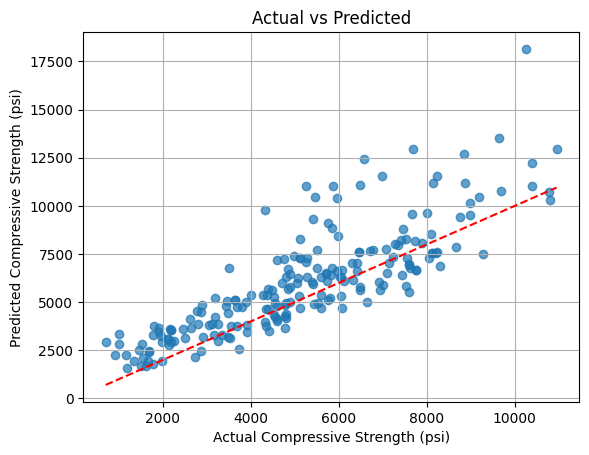

In [36]:
y_pred = mod.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Compressive Strength (psi)")
plt.ylabel("Predicted Compressive Strength (psi)")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.grid(True)
plt.show()
